<div style="border: 5px solid #2e3b4e; border-radius: 35px; padding: 20px; font-family: Arial, sans-serif; line-height: 1.6; background-color: #FF0000; color: #2e3b4e;">
  <h2>Overview of Kaggle Competition: Playground Series S5E1</h2>
  <ol>
    <li><b>Objective:</b> Predict the future sales of a retail chain using past sales data, taking into account factors like date, store, and product details.</li>
    <li><b>Data:</b>
      <ul>
        <li>Training data includes historical sales records with features such as date, store, and product category.</li>
        <li>Test data contains similar features but without target sales values for prediction.</li>
      </ul>
    </li>
    <li><b>Evaluation Metric:</b> Submissions are evaluated using Root Mean Squared Error (RMSE) on the test dataset. Lower RMSE indicates better performance.</li>
    <li><b>Competition Focus:</b>
      <ul>
        <li>Focus on time-series forecasting techniques and handling structured data with seasonal and promotional patterns.</li>
        <li>Leverage feature engineering, including encoding categorical data, handling missing values, and incorporating external features like holidays and events.</li>
      </ul>
    </li>
    <li><b>Learning Opportunity:</b> This competition provides an excellent opportunity to practice and learn time-series forecasting and regression models. It also allows experimentation with different feature engineering approaches to improve predictions.</li>
  </ol>
</div>


<a id="dataset-analysis"></a>
<p style="padding:30px;background-color:#FF0000;margin:0;color:#2e3b4e;font-family:Arial,sans-serif;font-size:250%;text-align:center;border-radius:10px;overflow:hidden;font-weight:800">
    🚀 Libraries 🚀

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.optimizers import Adam

<a id="dataset-analysis"></a>
<p style="padding:30px;background-color:#FF0000;margin:0;color:#2e3b4e;font-family:Arial,sans-serif;font-size:250%;text-align:center;border-radius:10px;overflow:hidden;font-weight:800">
    🚀 Data Exploring and Analysis 🚀

In [2]:
# Load dataset
train_data = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
test_data=pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')

<a id="dataset-analysis"></a>
<p style="padding:30px;background-color:#FF0000;margin:0;color:#2e3b4e;font-family:Arial,sans-serif;font-size:250%;text-align:center;border-radius:10px;overflow:hidden;font-weight:800">
    🚀 Preprocessing 🚀

In [3]:
# Preprocessing
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['Year'] = train_data['date'].dt.year
train_data['Month'] = train_data['date'].dt.month
train_data['Day'] = train_data['date'].dt.day
train_data = train_data.drop(['id', 'date'], axis=1)
train_data['num_sold'] = np.log1p(train_data['num_sold'])

# Encode categorical columns
categorical_cols = ['country', 'store', 'product']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    label_encoders[col] = le

# Split features and target
X = train_data.drop('num_sold', axis=1)
y = train_data['num_sold']

# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure that X and y have the same number of samples
train_data = train_data.dropna(subset=['num_sold'])  # Drop rows where 'num_sold' is NaN

# Split features and target again after dropping rows with NaN in the target
X = train_data.drop('num_sold', axis=1)
y = train_data['num_sold']

# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale input features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Scale target variable
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1))

# Ensure the same length after scaling
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape}")


# Reshape inputs for LSTM
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_valid_reshaped = X_valid_scaled.reshape(X_valid_scaled.shape[0], 1, X_valid_scaled.shape[1])


X_train_scaled shape: (177007, 6)
y_train_scaled shape: (177007, 1)


<a id="dataset-analysis"></a>
<p style="padding:30px;background-color:#FF0000;margin:0;color:#2e3b4e;font-family:Arial,sans-serif;font-size:250%;text-align:center;border-radius:10px;overflow:hidden;font-weight:800">
    🚀 LSTM 🚀

In [4]:
from tensorflow.keras.layers import Dropout

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, activation='relu', return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
lstm_model.summary()


# Train the model
history = lstm_model.fit(X_train_reshaped, y_train_scaled, epochs=20, batch_size=32, validation_data=(X_valid_reshaped, y_valid_scaled))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 50)               │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,851 (202.54 KB)

 Trainable params: 51,851 (202.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.4002 - val_loss: 0.0195
Epoch 2/20
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0539 - val_loss: 0.0127
Epoch 3/20
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0411 - val_loss: 0.0112
Epoch 4/20
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0360 - val_loss: 0.0096
Epoch 5/20
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0331 - val_loss: 0.0101
Epoch 6/20
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0314 - val_loss: 0.0097
Epoch 7/20
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0302 - val_loss: 0.0088
Epoch 8/20
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0293 - val_loss: 0.0080
Epoch 9/20
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0283 - val_loss: 0.0086
Epoch 10/20
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0279 - val_loss: 0.0078
Epoch 11/20
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0276 - val_loss: 0.0084
Epoch 12/20
5532/5532 ━━━━━━━

In [5]:
y_valid_pred = lstm_model.predict(X_valid_reshaped)
y_valid_pred = target_scaler.inverse_transform(y_valid_pred)  # Convert predictions back to original scale
y_valid_pred_original = np.expm1(y_valid_pred)
print(y_valid_pred_original)

# Calculate MAPE on the validation data
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(np.expm1(y_valid), np.expm1(y_valid_pred))
print(f"LSTM Validation MAPE: {mape}")

1383/1383 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
[[1373.4017  ]
 [1057.8514  ]
 [ 328.99124 ]
 ...
 [  21.340075]
 [1239.5334  ]
 [1077.538   ]]
LSTM Validation MAPE: 0.10206269295470809


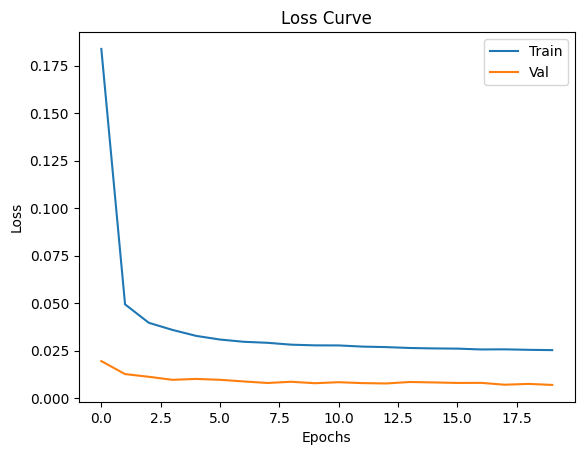

In [6]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


<a id="dataset-analysis"></a>
<p style="padding:30px;background-color:#FF0000;margin:0;color:#2e3b4e;font-family:Arial,sans-serif;font-size:250%;text-align:center;border-radius:10px;overflow:hidden;font-weight:800">
    🚀 GRU 🚀

In [7]:
gru_model = Sequential()
gru_model.add(GRU(64, activation='relu', input_shape=(1, X_train_reshaped.shape[2])))
gru_model.add(Dense(1))

gru_model.compile(optimizer='adam', loss='mse')

gru_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_valid_reshaped, y_valid))


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5532/5532 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 4.7604 - val_loss: 0.8325
Epoch 2/50
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.6601 - val_loss: 0.0820
Epoch 3/50
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0458 - val_loss: 0.0216
Epoch 4/50
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0187 - val_loss: 0.0165
Epoch 5/50
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0177 - val_loss: 0.0190
Epoch 6/50
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0172 - val_loss: 0.0162
Epoch 7/50
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0159 - val_loss: 0.0154
Epoch 8/50
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0155 - val_loss: 0.0198
Epoch 9/50
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0152 - val_loss: 0.0139
Epoch 10/50
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0148 - val_loss: 0.0154
Epoch 11/50
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0144 - val_loss: 0.0174
Epoch 12/50
5532/5532 ━━━━━━━━━━━━━━━━━━

In [8]:
# GRU Predictions
gru_preds = np.expm1(gru_model.predict(X_valid_reshaped))
gru_mape = mean_absolute_percentage_error(np.expm1(y_valid), gru_preds)
print(f"GRU Validation MAPE: {gru_mape}")

1383/1383 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
GRU Validation MAPE: 0.08287625444021057


In [9]:
gru_preds

array([[1317.8733  ],
       [1034.6088  ],
       [ 309.00308 ],
       ...,
       [  21.550407],
       [1251.8961  ],
       [1001.7323  ]], dtype=float32)

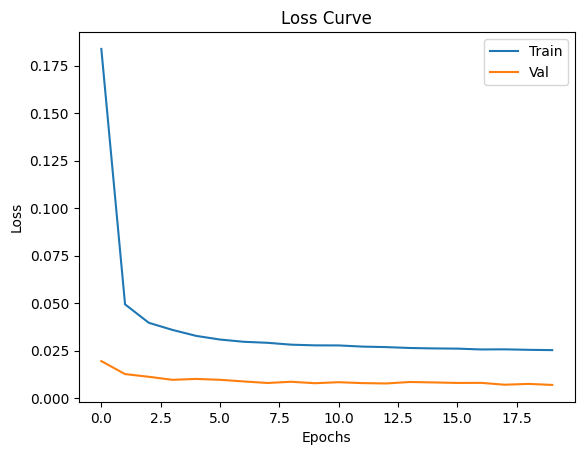

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
# Preprocess test data (apply the same transformations as done for training data)
test_data['date'] = pd.to_datetime(test_data['date'])
test_data['Year'] = test_data['date'].dt.year
test_data['Month'] = test_data['date'].dt.month
test_data['Day'] = test_data['date'].dt.day
test_data = test_data.drop(['id', 'date'], axis=1)

# Encode categorical columns in test data (use the same label encoders as for training)
for col in categorical_cols:
    test_data[col] = label_encoders[col].transform(test_data[col])

# Extract features (X_test) for the test data
X_test = test_data  # Replace this if there are any additional feature transformations

# Scale the test features
X_test_scaled = scaler.transform(X_test)

# Reshape the test features for GRU
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Predict on the test data using the GRU model
gru_test_preds = np.expm1(gru_model.predict(X_test_reshaped))  # Reverse log1p transformation


3080/3080 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [12]:
# Prepare the submission DataFrame
test_data=pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')
submission = pd.DataFrame({
    'id': test_data['id'],  # Assuming the 'id' column is in the test data
    'num_sold': gru_test_preds.flatten()  # Flatten the predictions and reverse the log1p transformation
})

# Save the submission file
submission.to_csv('submission_gru.csv', index=False)
submission

,id,num_sold
0,230130,104.937462
1,230131,662.619690
2,230132,542.161499
3,230133,295.590607
4,230134,337.755554
...,...,...
98545,328675,285.505646
98546,328676,1754.570435
98547,328677,1411.246948
98548,328678,875.754089
